In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_recall_fscore_support

In [55]:
def read_and_preprocess(path):
    archive = zipfile.ZipFile(path, 'r')
    file = archive.open("MetroPT3(AirCompressor).csv")
    df = pd.read_csv(file)
    df.drop("Unnamed: 0",axis=1,inplace=True)
    df["Failure"] = 0
    df.timestamp = pd.to_datetime(df.timestamp)
    df["Hour"] = df.timestamp.dt.hour
    df["Minute"] = df.timestamp.dt.minute

    df = df.set_index("timestamp")
    df.loc["2020-04-18 00:00:00":"2020-04-18 23:59:00","Failure"] = 1
    df.loc["2020-05-29 23:30:00":"2020-05-30 06:00:00","Failure"] = 1
    df.loc["2020-06-05 10:00:00":"2020-06-07 14:30:00","Failure"] = 1
    df.loc["2020-07-15 14:30:00":"2020-07-15 19:00:00","Failure"] = 1
    df = df.resample("1T").mean()
    df = df.dropna()
    
    print("Reading and preprocess is successful!")
    return df

def draw_heatmap(df,figsize,dpi,save=False,f_name=None):
    corr_df = df.corr()
    plt.figure(figsize=figsize,dpi=dpi)
    sns.heatmap(corr_df,annot=True,fmt=".3f",annot_kws={"size":5})
    if save:
        if f_name == None:
            raise Exception("You have to give filename as input!")
        plt.savefig("plots/" + f_name + ".png")
    plt.show()
    return None


def visualize_timeseries(df,start_time,day_count:int,hour_count,col,save=False):
    '''
    day_count: number of days to add to the start time
    hour_count: number of hours to add to the start_time
    save: if True, saves the figure
    
    '''
    start_time = pd.to_datetime(start_time)
    end_time = start_time + datetime.timedelta(days=day_count,hours=hour_count)
    

    
    
    df_slice = df.loc[start_time:end_time]


    failure_data_idx = df_slice[df_slice["Failure"]==1].index
    non_failure_data_idx = df_slice[df_slice["Failure"]==0].index

    plt_name = f"{col} plot from {start_time} - {end_time}"
    plt.figure(figsize=(15,5))
    plt.title(plt_name)

    for idx in df_slice.index:
        if idx in failure_data_idx:
            plt.plot(idx,df_slice.loc[idx][col],"r.")
        elif idx in non_failure_data_idx:
            plt.plot(idx,df_slice.loc[idx][col],"b.")

    # plt.plot(failure_data_idx,df_slice.loc[failure_data_idx][col],"r-")
    # plt.plot(non_failure_data_idx,df_slice.loc[non_failure_data_idx][col],"b-")

    
    
    # sns.scatterplot(data=df_slice,x=df_slice.index,y=col,hue="Failure")
    if save:
        plt.savefig("plots/" + plt_name + ".png")
    
    plt.show()
    return None
    
    

In [56]:
data = read_and_preprocess("data.zip")

Reading and preprocess is successful!


### Eliminating Highly Corralated Features

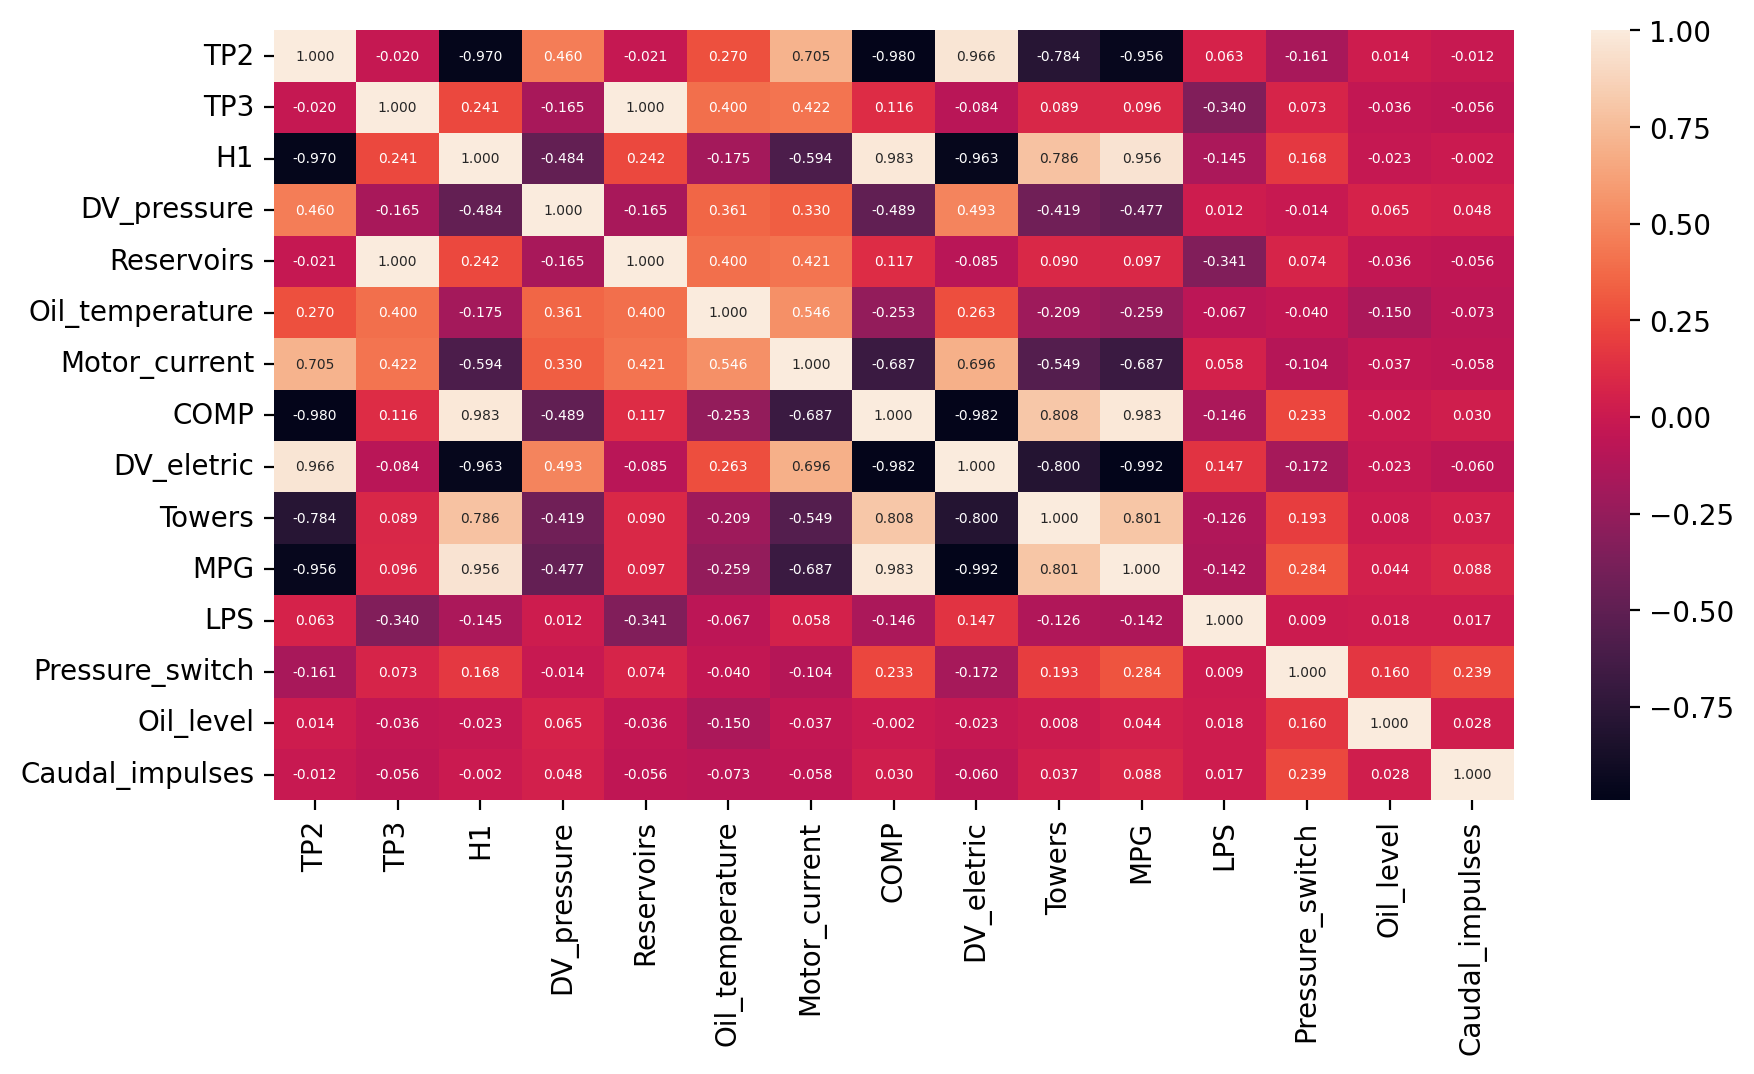

In [57]:
draw_heatmap(data[data.columns[:-3]],figsize=(10,5),dpi=200,save=True,f_name="heatmap_before_feature_elim")

Highly Corralated Features : TP2-H1 TP2-COMP TP2-MPG TP2-DV_eletric, TP3 - Reservoirs

In [58]:
TP2_high_correlation = ["H1","COMP","MPG","DV_eletric"]
TP3_high_correlation = ["Reservoirs"]

In [59]:
data = data.drop(columns=TP2_high_correlation + TP3_high_correlation)
data = data.drop(columns=["Caudal_impulses","Oil_level","LPS","Towers"])

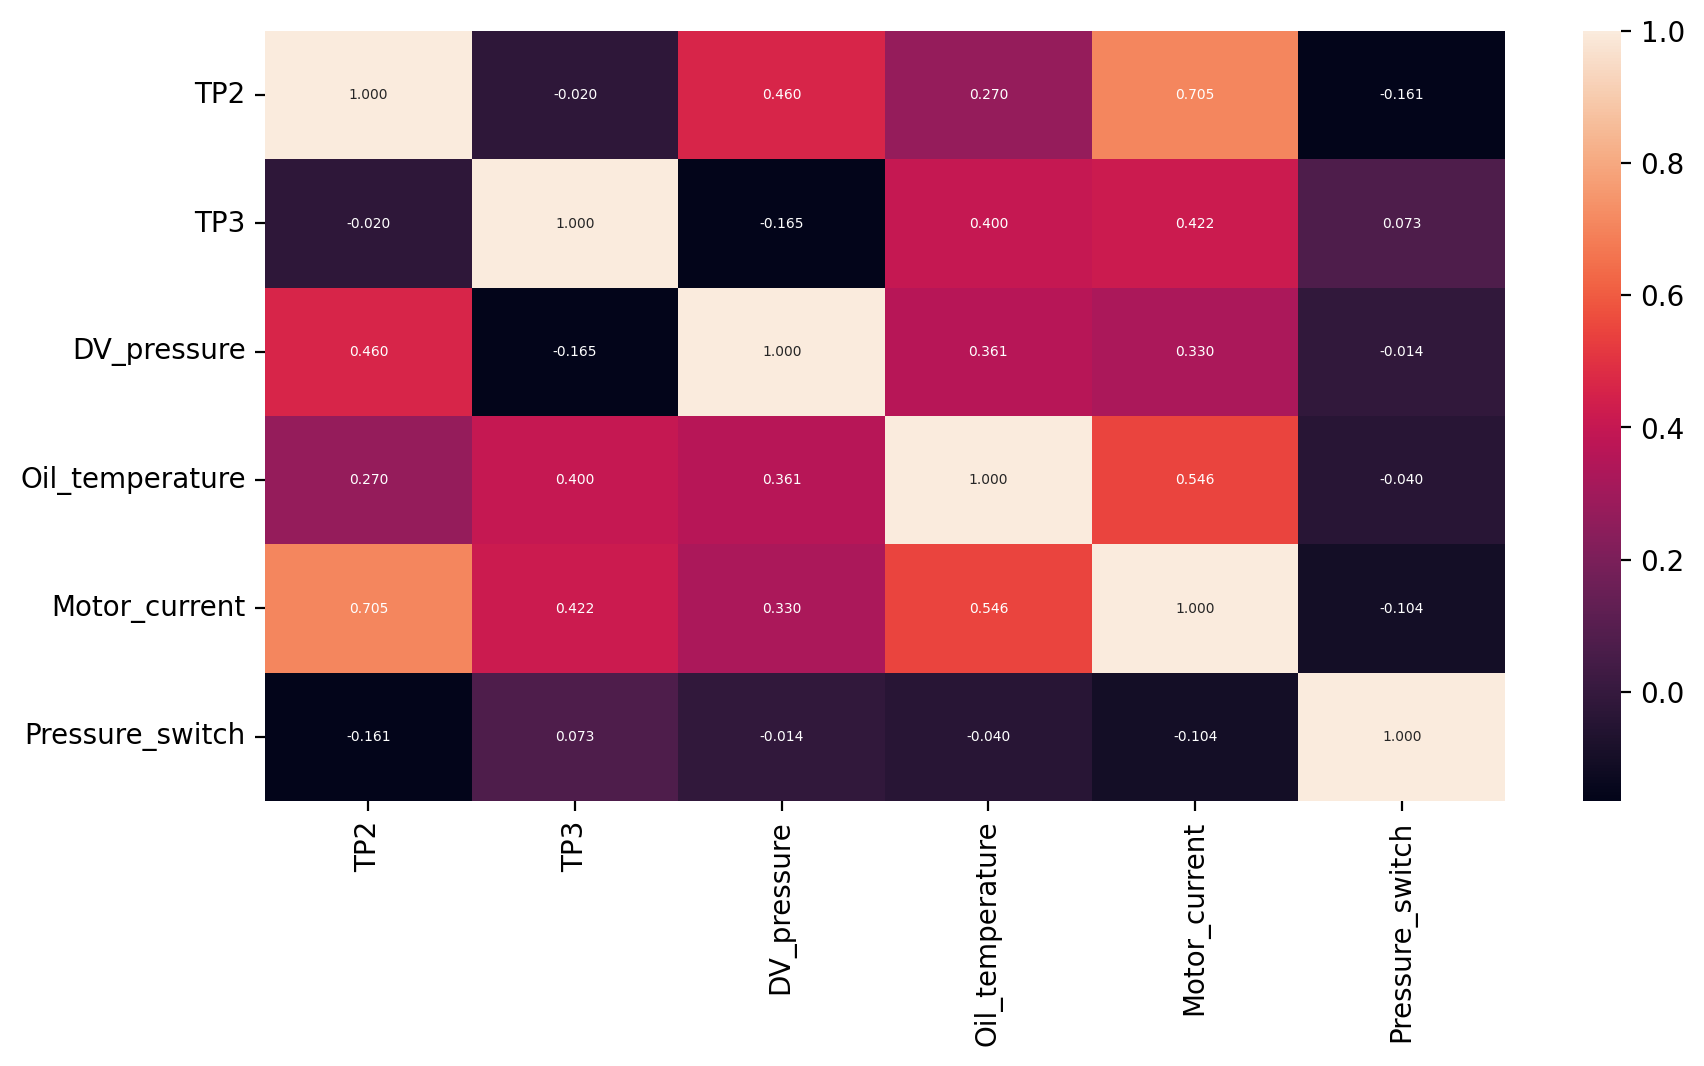

In [60]:
draw_heatmap(data[data.columns[:-3]],figsize=(10,5),dpi=200,save=True,f_name="heatmap_after_feature_elim")

In [61]:
print("Data Summary when there is a failure")
failure_df = data[data.Failure == 1]
failure_df.describe().T

Data Summary when there is a failure


,count,mean,std,min,25%,50%,75%,max
TP2,4957.0,8.107894,0.782519,-0.018,7.867667,8.060333,8.475333,10.322667
TP3,4957.0,8.286707,0.498379,2.936,7.967667,8.171333,8.750000,10.122667
DV_pressure,4957.0,1.857735,0.484115,-0.024,1.872333,1.952000,2.072000,2.201000
Oil_temperature,4957.0,75.573604,3.036478,40.965,74.750000,75.454167,76.162500,88.795833
Motor_current,4957.0,5.527654,0.367444,0.040,5.484167,5.531250,5.626667,6.071250
Pressure_switch,4957.0,0.994553,0.030540,0.600,1.000000,1.000000,1.000000,1.000000
Failure,4957.0,1.000000,0.000000,1.000,1.000000,1.000000,1.000000,1.000000
Hour,4957.0,11.019770,6.867918,0.000,5.000000,11.000000,17.000000,23.000000
Minute,4957.0,29.619931,17.351154,0.000,15.000000,30.000000,45.000000,59.000000


In [62]:
print("Data Summary when there isn't a failure")
non_failure_df = data[data.Failure == 0]
non_failure_df.describe().T

Data Summary when there isn't a failure


,count,mean,std,min,25%,50%,75%,max
TP2,247762.0,1.246300,2.947845,-0.025667,-0.013667,-0.012000,-0.010000,10.497000
TP3,247762.0,8.994812,0.631410,0.808000,8.502667,8.973000,9.499667,10.252000
DV_pressure,247762.0,0.019330,0.244253,-0.031333,-0.022333,-0.020000,-0.017667,3.526000
Oil_temperature,247762.0,62.384208,6.285282,15.400000,57.683333,62.600000,66.945833,82.958333
Motor_current,247762.0,1.986755,2.199431,0.020000,0.040833,0.044583,3.786071,6.363333
Pressure_switch,247762.0,0.989947,0.047464,0.000000,1.000000,1.000000,1.000000,1.000000
Failure,247762.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hour,247762.0,11.682139,6.604597,0.000000,6.000000,12.000000,17.000000,23.000000
Minute,247762.0,29.520423,17.322470,0.000000,15.000000,30.000000,45.000000,59.000000


In [63]:
FEATURES = data.drop("Failure",axis=1).columns
TARGET = "Failure"

In [64]:
FEATURES

Index(['TP2', 'TP3', 'DV_pressure', 'Oil_temperature', 'Motor_current',
       'Pressure_switch', 'Hour', 'Minute'],
      dtype='object')

In [76]:
#Manually Splitting the data since this is a time series data
test_start_date = "2020-07-02 00:00:00"
train_end_date = "2020-07-01 23:59:55"

X = data[FEATURES]
y = data[TARGET].astype(int)
X_train , y_train, X_test, y_test = X.loc[:train_end_date],y.loc[:train_end_date], X.loc[test_start_date:], y.loc[test_start_date:]
y_train = y_train


In [77]:
X_train

,TP2,TP3,DV_pressure,Oil_temperature,Motor_current,Pressure_switch,Hour,Minute
timestamp,,,,,,,,
2020-02-01 00:00:00,-0.012286,9.327429,-0.022857,53.521429,0.040357,1.0,0.0,0.0
2020-02-01 00:01:00,-0.013000,9.260000,-0.023333,53.420833,0.040000,1.0,0.0,1.0
2020-02-01 00:02:00,-0.012667,9.198333,-0.022333,53.325000,0.040000,1.0,0.0,2.0
2020-02-01 00:03:00,-0.012333,9.136667,-0.022667,53.200000,0.040000,1.0,0.0,3.0
2020-02-01 00:04:00,-0.013000,9.075667,-0.023000,53.129167,0.040000,1.0,0.0,4.0
...,...,...,...,...,...,...,...,...
2020-07-01 23:55:00,-0.011667,9.072000,-0.020333,64.108333,0.042500,1.0,23.0,55.0
2020-07-01 23:56:00,-0.012000,8.969333,-0.020333,63.129167,0.042083,1.0,23.0,56.0
2020-07-01 23:57:00,-0.012000,8.869333,-0.020667,62.437500,0.042500,1.0,23.0,57.0


### Feature Engineering

In [78]:
from sklearn.model_selection import TimeSeriesSplit
tss_idx = TimeSeriesSplit(n_splits=4)

In [82]:
num_cols = [col for col in X_train.columns if X_train[col].nunique() > 60] 

In [83]:
ct = ColumnTransformer(
    [
        ("num",StandardScaler(),num_cols)
    ]
)


pipe = Pipeline([
    ("ColTrans",ct),
    ("Model",RandomForestClassifier())
])

In [84]:
pipe.fit(X_train,y_train)


Pipeline(steps=[('ColTrans',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['TP2', 'TP3', 'DV_pressure',
                                                   'Oil_temperature',
                                                   'Motor_current'])])),
                ('Model', RandomForestClassifier())])

In [85]:
x_test_score =pipe.score(X_test,y_test)
all_zeros_score = pipe.score(X_test,np.zeros(len(y_test)))

In [112]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pipe.predict(X_test))

<Axes: >

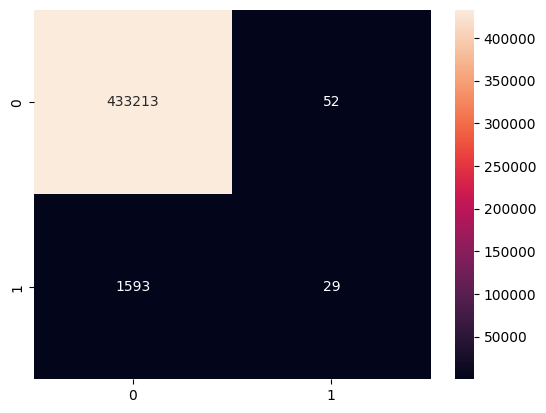

In [113]:
sns.heatmap(cm,annot=True,fmt=".0f")